In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np 


import torch
import torch.nn as nn

from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from torchsampler import ImbalancedDatasetSampler


from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm

import matplotlib.pyplot as plt


import torchvision.models as models 
from utils.models import *
import utils.loss 

from sklearn.metrics import recall_score, f1_score, accuracy_score

In [8]:
model_path = './model/unet_sonography_240124/unet_sonography_240124_94_e.pt'
checkpoint = torch.load(model_path)
model = pretrained_unet_encoder_binary()
model.to('cuda')
model.load_state_dict(checkpoint['model_state_dict'])

epochs = checkpoint['epochs']

Using cache found in C:\Users\dablr/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


500

In [26]:
checkpoint.keys()

dict_keys(['model', 'epoch', 'epochs', 'model_state_dict', 'optimizer_state_dict', 'learning_rate', 'loss', 'metric', 'description'])

In [27]:
checkpoint['loss']

BCEWithLogitsLoss()

In [22]:
train_dir = '../data/data_bin_crop_margin/train'
valid_dir = '../data/data_bin_crop_margin/valid'



train_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias= True), # 혹은 모델에 맞는 다른 사이즈로 조정
    transforms.ToTensor(),
    transforms.RandomApply([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33), antialias= True),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
    ], p=0.7),
])



valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    # transforms.Resize((299,299), antialias=True),
    transforms.Grayscale(num_output_channels=3),
    # transforms.Normalize((0.5), (0.5)),
])
# batch
tr_batch = 50
vl_batch = 25


train_dataset = CustomDataset(root_dir = train_dir, transform= train_transform)
valid_dataset = CustomDataset(root_dir = valid_dir, transform= valid_transform)

# 배치샘플러 생성(1:1비율로 배치에 클래스 데이터 존재), DataLoader 생성
# balanced_batch_sampler = BalancedBatchSampler(train_dataset, batch_size=tr_batch)

# train_loader = DataLoader(dataset=train_dataset, batch_sampler=balanced_batch_sampler)
train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset, labels = train_dataset.getlabels()), batch_size = tr_batch,)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)

In [23]:
# batch sampler test
for i, (image, label) in enumerate(train_loader):
    unique, cnts = np.unique(label, return_counts= True)
    print(dict(zip(unique, cnts)))
    break

{0.0: 22, 1.0: 28}


train_input_shape : torch.Size([50, 3, 224, 224])
intensity check : 0.0~1.0
****************************************************************************************************


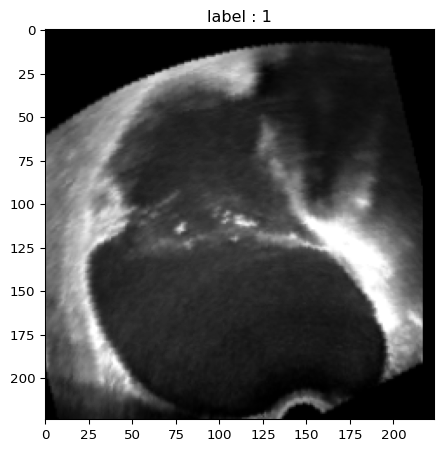

In [10]:
for images, labels in train_loader:
    print(f'train_input_shape : {images.shape}')
    break 
# for images, labels in valid_loader:
#     print(f'valid_input_shape : {images.shape}')
#     break 

print(f"intensity check : {images.min()}~{images.max()}")
print('*'*100)
plt.figure(dpi = 96)
plt.subplot(111)
plt.imshow(images[0,0,:,:], cmap= 'gray')
plt.title(f'label : {labels[0].to(int).item()}')
# plt.title(f'type 1')
# plt.subplot(132)
# plt.imshow(images[0,1,:,:], cmap= 'gray')
# plt.title(f'type 2')
# plt.subplot(133)
# plt.imshow(images[0,2,:,:], cmap= 'gray')
# plt.title(f'type 3')
plt.tight_layout()
plt.show()


In [13]:
import torch
import torch.nn as nn
from torchsummary import summary
from utils import models
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'device : {device}')

pretrained_model = models.pretrained_convnext_binary()
pretrained_model.to(device)
# cost func & optimizer 정의
epoch, epochs = 0, 200
lr = 0.0001
# loss = custom_loss.FocalLoss().to(device)
loss = nn.BCEWithLogitsLoss().to(device) #-> 마지막 layer에 softmax/sigmoid 함수 넣어주기 

optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr = lr)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer, lr_lambda = lambda epcoh: 0.95)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer,
                                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                                        last_epoch = -1,
                                                        verbose= True)
# 모델 구조 출력 
print(f"cuda : {device}")
summary(pretrained_model, input_size=(3, 224, 224), device = 'cpu')

device : cpu


c:\Users\dablr\.conda\envs\eiden\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adjusting learning rate of group 0 to 1.0000e-04.
cuda : cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           6,272
       LayerNorm2d-2          [-1, 128, 56, 56]             256
            Conv2d-3          [-1, 128, 56, 56]           6,400
           Permute-4          [-1, 56, 56, 128]               0
         LayerNorm-5          [-1, 56, 56, 128]             256
            Linear-6          [-1, 56, 56, 512]          66,048
              GELU-7          [-1, 56, 56, 512]               0
            Linear-8          [-1, 56, 56, 128]          65,664
           Permute-9          [-1, 128, 56, 56]               0
  StochasticDepth-10          [-1, 128, 56, 56]               0
          CNBlock-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]           6,400
          Permute-13          [-1, 56, 56,

In [14]:
pretrained_model

pretrained_convnext_binary(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
   

In [15]:
metrics = {
    'train_loss' : [],
    'valid_loss' : [],
    'train_accuracy' : [],
    'train_f1' : [],
    'train_recall' : [],
    'valid_accuracy' : [],
    'valid_f1' : [],
    'valid_recall' : [],
}


In [16]:
# 조기 종료 변수 초기화
early_stopping_epochs, early_stop_cnt = 10, 0
best_loss = float('inf')


for epoch in tqdm(range(epoch, epochs)):
    
    train_losses = 0. 
    valid_losses = 0. 

    train_target, train_pred, valid_target, valid_pred = [],[],[],[]
    
    pretrained_model.train()
    for _, (inputs, labels) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad() 
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = pretrained_model(inputs)
        
        train_loss = loss(outputs, labels)
        # print(train_loss)
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        
        # 예측 값을 이진 레이블로 변환
        pred = (F.sigmoid(outputs) > 0.5).float()
        train_target.extend(labels.detach().cpu().numpy())
        train_pred.extend(pred.detach().cpu().numpy())
    
    metrics['train_loss'].append(train_losses/len(train_loader))
    metrics['train_accuracy'].append(accuracy_score(train_target, train_pred))
    metrics['train_f1'].append(f1_score(train_target, train_pred))
    metrics['train_recall'].append(recall_score(train_target, train_pred))
    
    scheduler.step()

    print(list(labels.cpu().numpy()))
    print(list(pred.cpu().numpy()))

    
    with torch.no_grad():
        pretrained_model.eval()
        for _, (inputs, labels) in tqdm(enumerate(valid_loader)):
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = pretrained_model(inputs)
            
            valid_loss = loss(outputs, labels)
            valid_losses += valid_loss.item()
            
            # 예측 값을 이진 레이블로 변환
            pred = (F.sigmoid(outputs) > 0.5).float()
            valid_target.extend(labels.detach().cpu().numpy())
            valid_pred.extend(pred.detach().cpu().numpy())
        metrics['valid_loss'].append(valid_losses/len(valid_loader))
        metrics['valid_accuracy'].append(accuracy_score(valid_target, valid_pred))
        metrics['valid_f1'].append(f1_score(valid_target, valid_pred))
        metrics['valid_recall'].append(recall_score(valid_target, valid_pred))
    
    
    
    print("#"*100)    
    print(f"LOSS : {metrics['train_loss'][-1]} | {metrics['valid_loss'][-1]}\n ACC : {metrics['train_accuracy'][-1]} | {metrics['valid_accuracy'][-1]}\n F1 : {metrics['train_f1'][-1]} | {metrics['valid_f1'][-1]}\n RECALL : {metrics['train_recall'][-1]} | {metrics['valid_recall'][-1]}")
    print("#"*100)
    
    
        
    # Early Stopping
    if valid_loss > best_loss:
        early_stop_cnt += 1
    else:
        best_loss = valid_loss
        early_stop_cnt = 0
    
    # 조기 종료 조건 확인
    if early_stop_cnt >= early_stopping_epochs:
        print(f"Early Stops!!! : {epoch}/{epochs}")
        
        torch.save({
            "model" : f"{epoch}",
            "epoch" : epoch,
            "epochs" : epochs,
            "model_state_dict" : pretrained_model.state_dict(),
            "optimizer_state_dict" : optimizer.state_dict(),
            "learning_rate" : lr,
            "loss" : loss,
            "metric" : metrics,
            "description" : f"vggnet training status : {epoch}/{epochs}"
        },
        f'./metric/vgg16.pt')
        
        print(f"SAVE MODEL PATH : ./model/model_check.pt")
        break
    else:
        if accuracy_score(valid_target, valid_pred) > np.array(metrics['valid_recall']).max():
            torch.save({
                "model" : f"{epoch}",
                "epoch" : epoch,
                "epochs" : epochs,
                "model_state_dict" : pretrained_model.state_dict(),
                "optimizer_state_dict" : optimizer.state_dict(),
                "learning_rate" : lr,
                "loss" : loss,
                "metric" : metrics,
                "description" : f"vggnet training status : {epoch}/{epochs}"
            },
            f'./metric/vgg16.pt')
            
            print(f"SAVE MODEL PATH : ./model/model_check.pt")


0it [00:28, ?it/s]/200 [00:00<?, ?it/s]
  0%|          | 0/200 [00:28<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
!